# Compute AU statistics

### import packages

In [1]:
import json
import pickle

import itertools
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

from matplotlib.lines import Line2D

### AU infos

from http://www.scholarpedia.org/article/Facial_expression_analysis

| Emotion   | AUs                           |
|-----------|-------------------------------|
| Anger     |  4, 5 and/or 7,  22, 23, 24   |
| Disgust   |    9 and/or 10,  (25 or 26)   |
| Fear      | 1, 2, 4, 5, 7, 20, (25 or 26) |
| Happiness | 6, 12                         |
| Sadness   | 1, (4), 15, (17)              |
| Surprise  |1, 2, 5, 25 o 26               |
| Fear      | 1, 2, 4, 5, 7, 20, (25 or 26) | 	

### settings 

In [2]:
with open('../models/average_im_dict.pkl', 'rb') as fp:
    avg_im_dict = pickle.load(fp)

with open('../models/palette.pkl', 'rb') as fp:
    color_palette = pickle.load(fp)

with open('../models/palette7.pkl','rb') as fp:
    palette7 = pickle.load(fp)

with open('../references/my_settings.json', 'r') as fp:
    settings_dict = json.load(fp)

my_order = settings_dict['my_order']
my_boot = settings_dict['boots']
my_ci = settings_dict['ci']

### get data

In [3]:
df = pd.read_csv('../data/processed/big_p_au_df.tsv',
            sep='\t',
            index_col=[0, 1, 2],
            header=[0, 1])

In [4]:
df

Image Fearful                 Disgusted              \
                     Image AU1+2+4 AU20 AU26 AU5+7   AU15+16  AU4 AU9+10   
p001 Full  Angry       9.4     0.2  1.5  2.3   3.7       1.9  0.8    1.1   
           Disgusted   9.0     0.3  1.3  1.4   2.7       1.4  0.9    2.2   
           Fearful     9.1     1.3  1.0  1.5   2.8       1.4  1.8    2.0   
           Happy       7.7     0.2  1.2  0.6   2.0       1.2  0.6    1.8   
           Neutral     7.8     0.8  1.4  1.5   2.5       1.7  1.1    1.4   
...                    ...     ...  ...  ...   ...       ...  ...    ...   
p233 Upper Fearful     4.5     1.9  0.0  0.0   0.2       0.0  2.0    0.0   
           Happy       3.9     0.2  0.0  0.0   0.8       0.0  0.2    0.8   
           Neutral     4.4     0.9  0.0  0.0   1.4       0.0  1.0    0.0   
           Sad         5.0     2.0  0.0  0.0   1.1       0.0  2.4    0.0   
           Surprised   4.5     1.5  0.0  0.0   1.3       0.0  0.7    0.0   

                     Happy        Sad      Angry              Surprised       \
                      AU12  AU6 AU1+4 AU15  AU23  AU4 AU7(+5)     AU1+2 AU26   
p001 Full  Angry       0.6  0.8   2.4  1.7   2.2  1.9     1.8       0.2  2.1   
           Disgusted   1.5  0.6   1.0  0.9   2.3  1.4     1.5       0.4  1.0   
           Fearful     0.4  1.1   2.4  1.2   1.7  1.8     2.2       1.3  1.6   
           Happy       2.5  1.5   1.0  1.2   0.9  0.7     1.7       0.3  0.6   
           Neutral     0.9  0.9   1.6  1.0   1.5  1.4     1.7       0.5  1.2   
...                    ...  ...   ...  ...   ...  ...     ...       ...  ...   
p233 Upper Fearful     0.0  0.3   1.9  0.0   0.0  2.0     0.4       1.9  0.0   
           Happy       0.0  2.7   0.3  0.0   0.0  0.2     0.5       0.2  0.0   
           Neutral     0.0  0.5   1.4  0.0   0.0  1.1     0.7       0.7  0.0   
           Sad         0.0  0.1   2.7  0.0   0.0  2.3     0.4       2.2  0.0   
           Surprised   0.0  0.3   1.8  0.0   0.0  0.7     0.8       1.2  0.0   

                           
                      AU5  
p001 Full  Angry      3.8  
           Disgusted  2.7  
           Fearful    2.2  
           Happy      1.5  
           Neutral    2.7  
...                   ...  
p233 Upper Fearful    0.3  
           Happy      0.4  
           Neutral    2.0  
           Sad        1.6  
           Surprised  1.8  

[4242 rows x 18 columns]

### clean up

Image is not interesting here

In [5]:
df = df.drop([('Image', 'Image')], axis=1)

### average over participants

In [6]:
mean_df = df.groupby(level=[1, 2]).mean()

In [7]:
mean_df.tail()

Fearful                               Disgusted            \
                  AU1+2+4      AU20      AU26     AU5+7   AU15+16       AU4   
Upper Fearful    2.139604  0.000000  0.000000  1.801485       0.0  1.910891   
      Happy      0.453465  0.000000  0.000000  1.785149       0.0  0.532673   
      Neutral    0.933663  0.000495  0.000495  1.661881       0.0  0.991584   
      Sad        1.969307  0.000000  0.000000  1.840594       0.0  1.955446   
      Surprised  2.154950  0.000000  0.000000  1.714851       0.0  0.632673   

                              Happy                 Sad               Angry  \
                   AU9+10      AU12       AU6     AU1+4      AU15      AU23   
Upper Fearful    0.378218  0.000000  0.467822  2.583663  0.000000  0.000000   
      Happy      0.865347  0.000000  2.056436  1.147030  0.000000  0.000000   
      Neutral    0.504455  0.000990  0.696040  1.631188  0.000495  0.000495   
      Sad        0.406931  0.000495  0.630198  2.558911  0.000000  0.000000   
      Surprised  0.374257  0.000000  0.454455  2.094554  0.000000  0.000000   

                                    Surprised                      
                      AU4   AU7(+5)     AU1+2      AU26       AU5  
Upper Fearful    1.880198  0.899505  2.080198  0.000000  1.763366  
      Happy      0.588614  1.222277  0.415347  0.000000  1.472772  
      Neutral    1.043069  0.845545  0.876733  0.000495  1.677723  
      Sad        1.949010  1.001980  1.937129  0.000495  1.800000  
      Surprised  0.588614  0.920792  2.254455  0.000000  1.739109

### only full condition

In [8]:
full_df = mean_df.loc['Full', :]

In [9]:
full_df

Fearful                               Disgusted            \
            AU1+2+4      AU20      AU26     AU5+7   AU15+16       AU4   
Angry      0.637129  0.842079  1.565842  1.439109  1.255941  1.257921   
Disgusted  0.455446  0.989604  1.243564  1.329703  1.088614  0.979208   
Fearful    1.396040  0.636139  1.499010  1.252970  1.151485  1.347030   
Happy      0.200990  1.059406  0.774257  1.039109  1.116337  0.239109   
Neutral    0.522277  0.868317  1.466337  1.064851  1.264851  0.509406   
Sad        1.376238  1.364851  1.658911  1.337624  1.500990  1.410396   
Surprised  1.443564  0.417822  1.722277  1.286634  1.174257  0.444059   

                        Happy                 Sad               Angry  \
             AU9+10      AU12       AU6     AU1+4      AU15      AU23   
Angry      0.961386  0.543069  0.341584  1.332178  0.983663  1.436634   
Disgusted  2.053465  1.130693  0.616832  0.946535  0.859901  1.513861   
Fearful    0.742079  0.499505  0.305941  1.736139  0.764851  1.572772   
Happy      0.937129  2.017327  1.247525  0.595050  1.075248  0.894059   
Neutral    0.452970  0.748515  0.452970  0.884653  0.984653  1.470297   
Sad        0.730693  1.147525  0.398515  1.798515  1.411881  1.534158   
Surprised  0.339604  0.216337  0.281683  1.428218  0.716337  1.614851   

                              Surprised                      
                AU4   AU7(+5)     AU1+2      AU26       AU5  
Angry      1.526238  0.736634  0.718317  1.481683  1.380198  
Disgusted  1.253465  0.809406  0.480693  1.018317  1.207921  
Fearful    1.333663  0.630693  1.360891  1.330198  1.261881  
Happy      0.263366  0.784653  0.178713  0.687129  0.901485  
Neutral    0.548515  0.583663  0.478218  1.446040  1.060396  
Sad        1.409406  0.718317  1.341584  1.621287  1.315347  
Surprised  0.399010  0.687624  1.472772  1.617822  1.325248

### correlation

<AxesSubplot:>

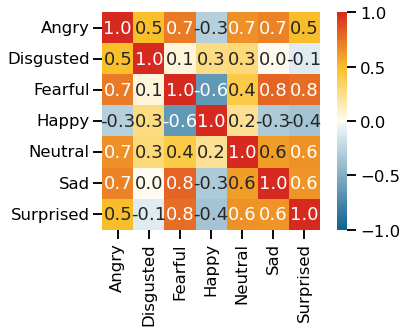

In [10]:
sns.heatmap(full_df.T.corr(), 
            cmap=color_palette, 
            vmin=-1, vmax=1, 
            square=True, 
            annot=True, 
            fmt='.1f')

/home/mwegrzyn/.conda/envs/faceparts/lib/python3.10/site-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


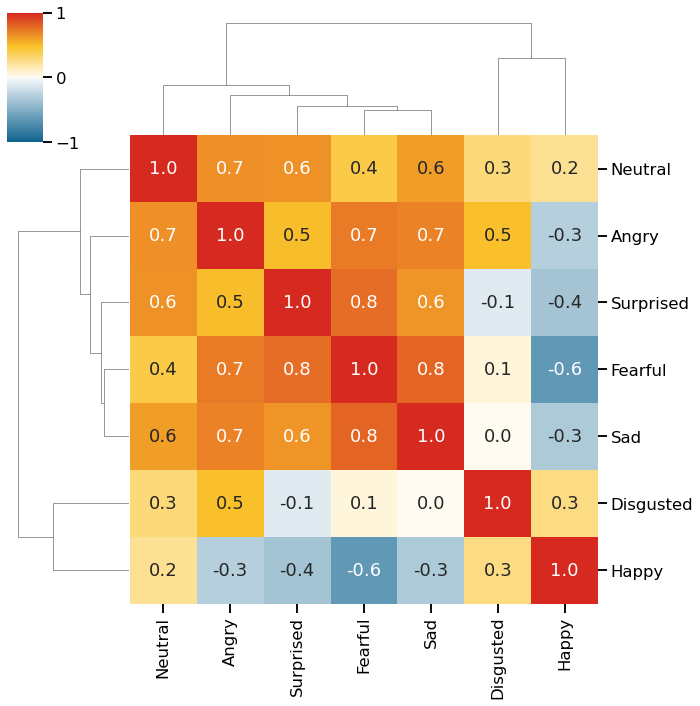

In [11]:
sns.clustermap(full_df.T.corr(), 
               cmap=color_palette, 
               vmin=-1, 
               vmax=1, 
               square=True, 
               annot=True, 
               fmt='.1f')

In [12]:
full_df.index

Index(['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad',
       'Surprised'],
      dtype='object')

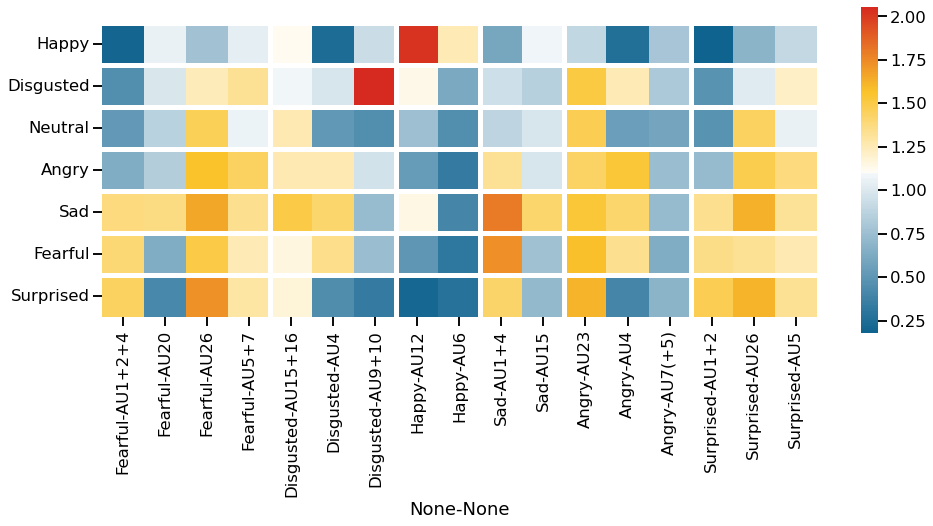

In [13]:
plt.figure(figsize=(16, 6))
sns.heatmap(full_df.loc[my_order, :],
            cmap=color_palette,
            square=True)
for i in [4,7,9,11,14]:
    plt.axvline(i, linewidth=5, color='white')
for i in range(7):
    plt.axhline(i, linewidth=5, color='white')

### get full condition

In [14]:
full_df = df.xs('Full', level=1)
full_df.tail()

Fearful                 Disgusted             Happy        Sad  \
               AU1+2+4 AU20 AU26 AU5+7   AU15+16  AU4 AU9+10  AU12  AU6 AU1+4   
p233 Fearful       0.8  0.5  1.7   0.3       1.2  0.8    0.2   0.3  0.2   0.8   
     Happy         0.0  1.6  0.3   0.7       1.4  0.0    0.3   1.8  0.9   0.2   
     Neutral       0.2  0.7  1.2   0.8       1.1  0.2    0.5   0.6  0.0   0.2   
     Sad           0.5  0.6  0.7   0.4       0.6  0.5    0.2   0.5  0.1   0.4   
     Surprised     0.5  0.5  2.0   0.9       1.0  0.4    0.0   0.0  0.1   0.8   

                    Angry              Surprised            
               AU15  AU23  AU4 AU7(+5)     AU1+2 AU26  AU5  
p233 Fearful    0.7   1.8  0.8     0.2       0.8  1.5  0.4  
     Happy      1.2   0.4  0.0     0.9       0.0  0.3  0.7  
     Neutral    1.1   1.1  0.2     0.5       0.2  1.2  0.9  
     Sad        0.6   0.7  0.5     0.1       0.5  0.6  0.7  
     Surprised  1.1   1.8  0.3     0.4       0.4  1.9  1.3

get mean for the AU over all conditions for that participant

In [15]:
full_mean_df = full_df.groupby(level=0, axis=0).mean()
full_mean_df.tail()

Fearful                               Disgusted                      \
       AU1+2+4      AU20      AU26     AU5+7   AU15+16       AU4    AU9+10   
p228  1.757143  1.157143  1.328571  1.314286  1.514286  1.528571  1.800000   
p230  0.171429  0.042857  1.042857  1.485714  0.728571  0.171429  0.200000   
p231  0.500000  1.257143  1.514286  1.157143  1.585714  0.742857  0.514286   
p232  0.628571  0.242857  1.028571  0.414286  0.657143  0.614286  0.285714   
p233  0.342857  0.642857  0.985714  0.771429  0.857143  0.471429  0.357143   

         Happy                 Sad               Angry                      \
          AU12       AU6     AU1+4      AU15      AU23       AU4   AU7(+5)   
p228  1.442857  0.714286  2.085714  1.271429  1.514286  1.742857  0.657143   
p230  0.057143  0.185714  0.400000  0.214286  1.014286  0.242857  0.928571   
p231  0.914286  0.542857  1.085714  1.471429  1.514286  0.871429  0.700000   
p232  0.414286  0.200000  0.828571  0.242857  1.071429  0.671429  0.171429   
p233  0.571429  0.300000  0.500000  0.757143  0.971429  0.514286  0.500000   

     Surprised                      
         AU1+2      AU26       AU5  
p228  1.800000  1.257143  1.028571  
p230  0.157143  0.914286  1.414286  
p231  0.571429  1.385714  1.128571  
p232  0.614286  0.871429  0.414286  
p233  0.371429  0.900000  0.928571

### remove global mean

In [16]:
clean_df = pd.DataFrame()
for i in full_df.index.levels[1]:
    this = full_df.xs(i, level=1)
    diff = this - full_mean_df
    
    diff.index = pd.MultiIndex.from_tuples([(j, i) for j in diff.index])
    
    clean_df = pd.concat([clean_df, diff])
    
clean_df = clean_df.sort_index()

In [17]:
clean_df.tail()

Fearful                               Disgusted            \
                 AU1+2+4      AU20      AU26     AU5+7   AU15+16       AU4   
p233 Fearful    0.457143 -0.142857  0.714286 -0.471429  0.342857  0.328571   
     Happy     -0.342857  0.957143 -0.685714 -0.071429  0.542857 -0.471429   
     Neutral   -0.142857  0.057143  0.214286  0.028571  0.242857 -0.271429   
     Sad        0.157143 -0.042857 -0.285714 -0.371429 -0.257143  0.028571   
     Surprised  0.157143 -0.142857  1.014286  0.128571  0.142857 -0.071429   

                             Happy        Sad               Angry            \
                  AU9+10      AU12  AU6 AU1+4      AU15      AU23       AU4   
p233 Fearful   -0.157143 -0.271429 -0.1   0.3 -0.057143  0.828571  0.285714   
     Happy     -0.057143  1.228571  0.6  -0.3  0.442857 -0.571429 -0.514286   
     Neutral    0.142857  0.028571 -0.3  -0.3  0.342857  0.128571 -0.314286   
     Sad       -0.157143 -0.071429 -0.2  -0.1 -0.157143 -0.271429 -0.014286   
     Surprised -0.357143 -0.571429 -0.2   0.3  0.342857  0.828571 -0.214286   

                       Surprised                 
               AU7(+5)     AU1+2 AU26       AU5  
p233 Fearful      -0.3  0.428571  0.6 -0.528571  
     Happy         0.4 -0.371429 -0.6 -0.228571  
     Neutral       0.0 -0.171429  0.3 -0.028571  
     Sad          -0.4  0.128571 -0.3 -0.228571  
     Surprised    -0.1  0.028571  1.0  0.371429

Example:

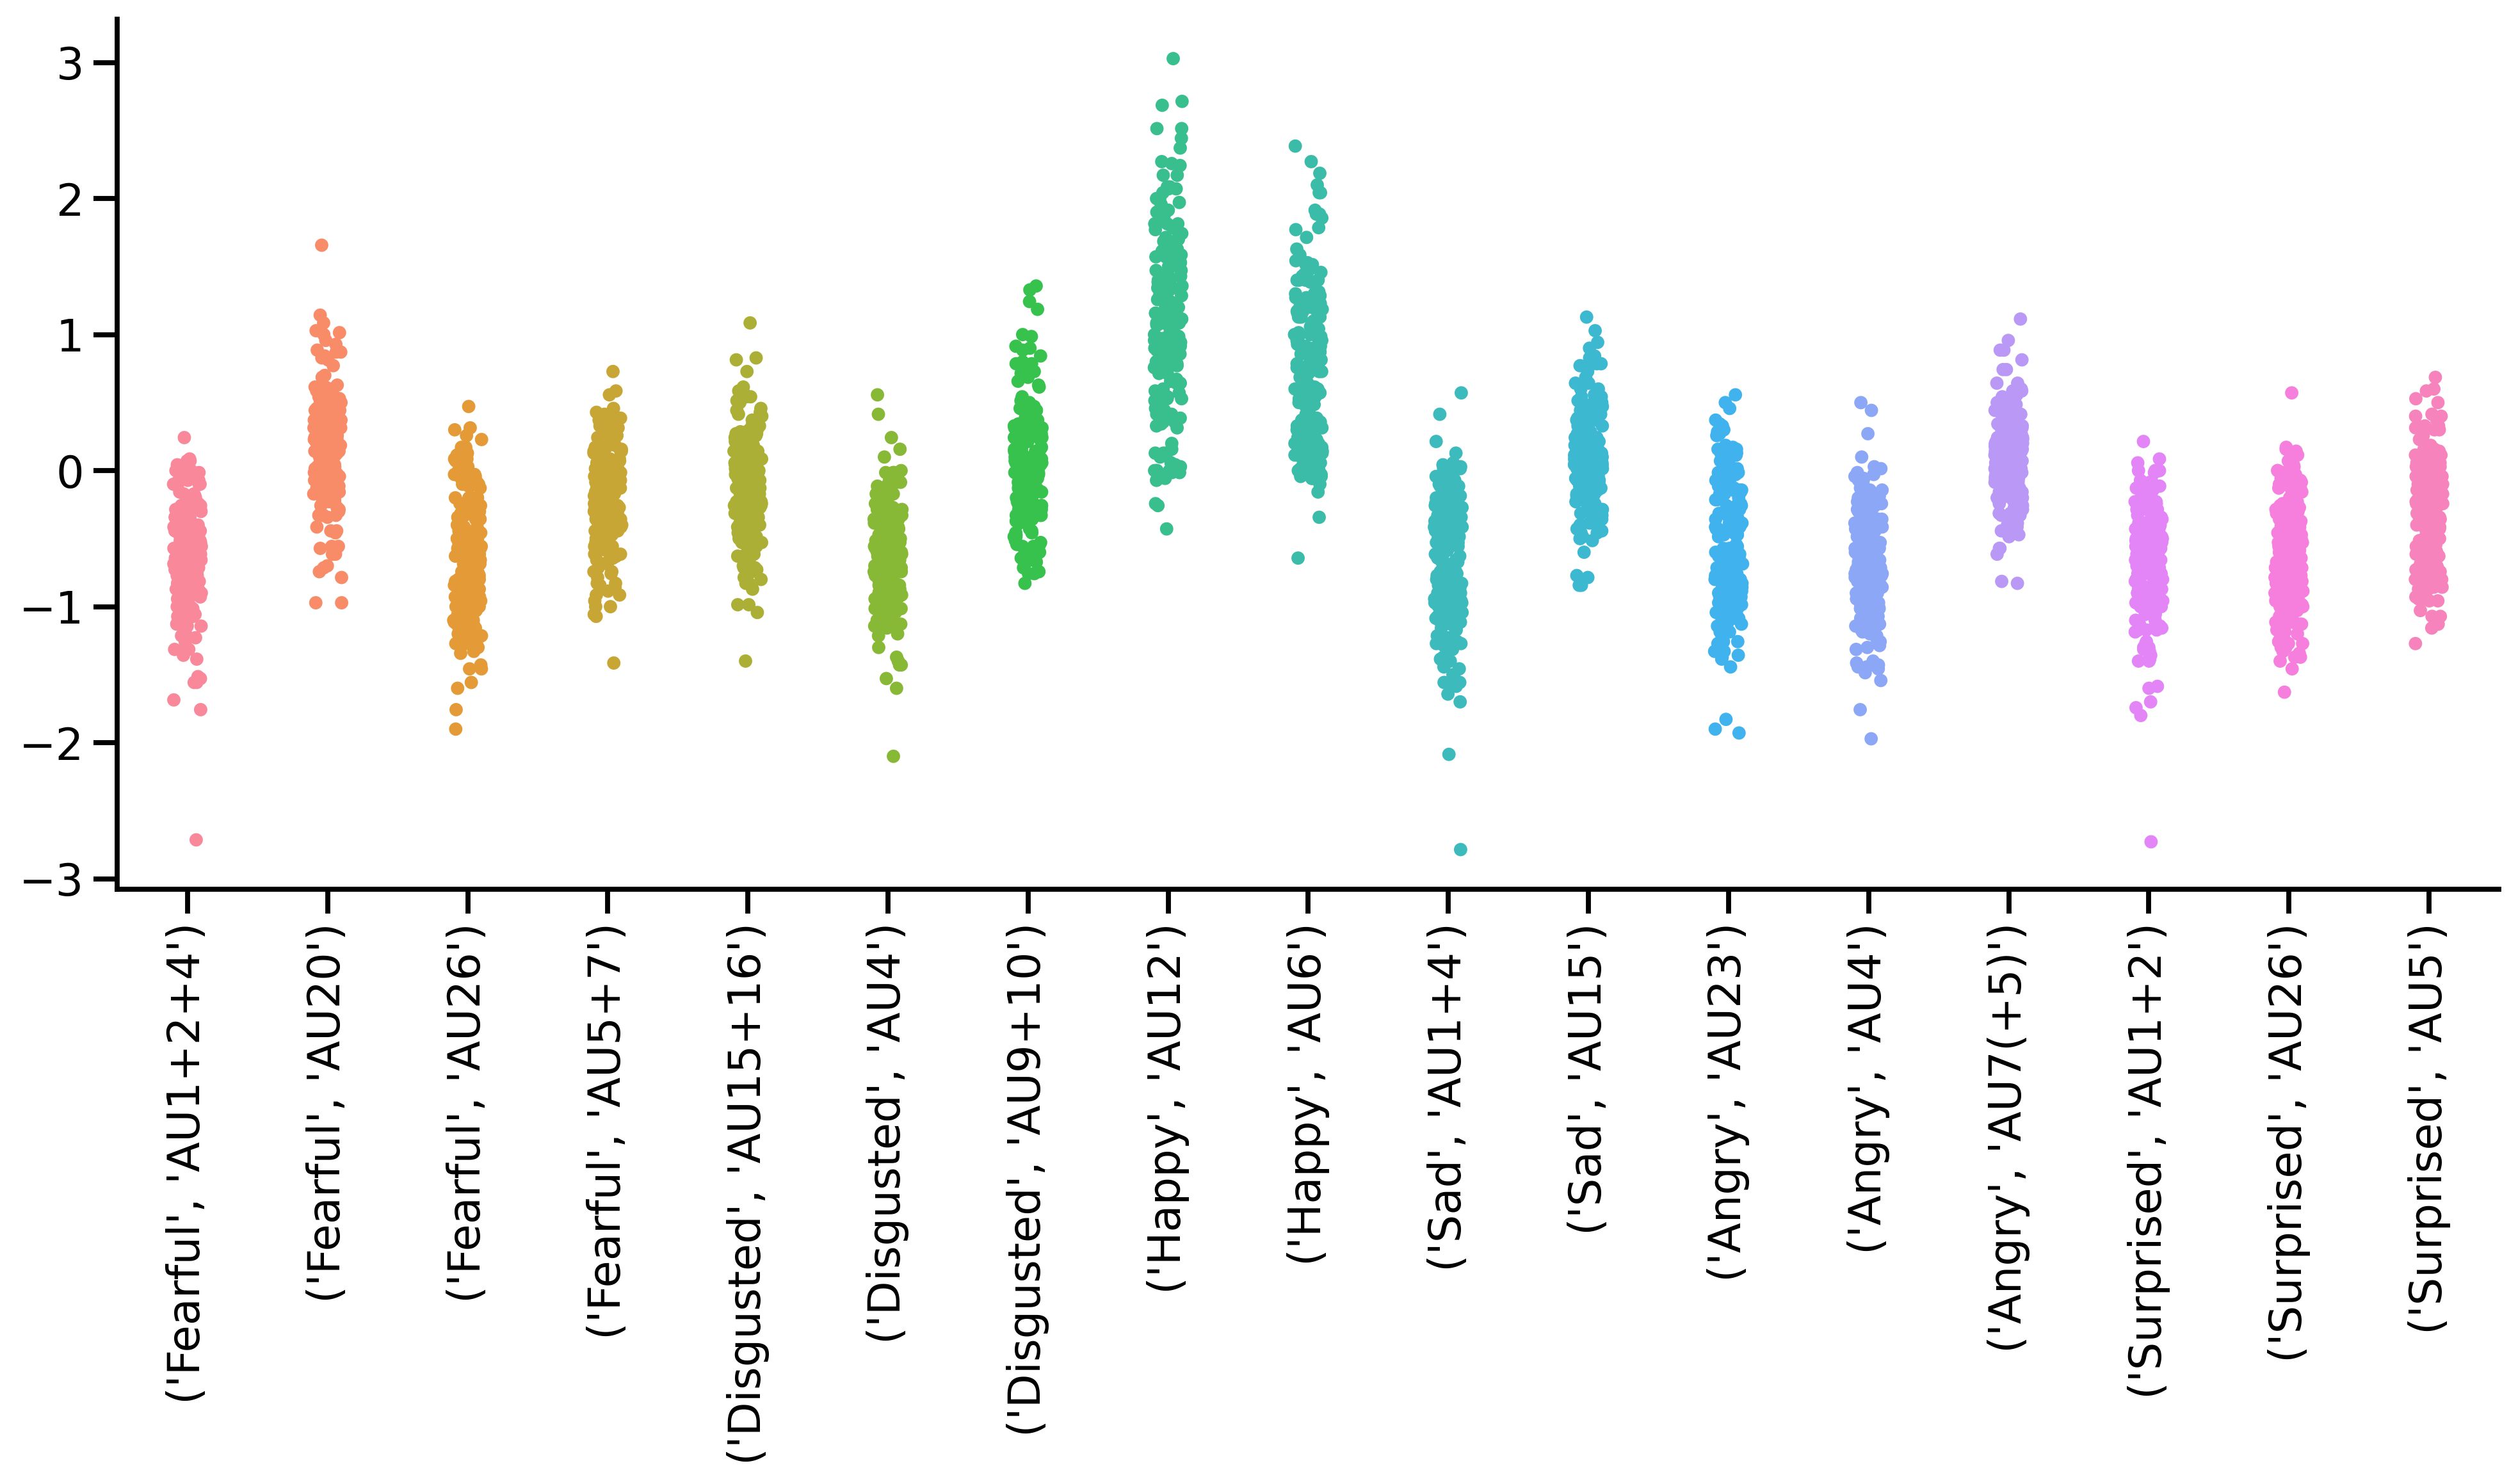

In [18]:
plt.figure(figsize=(16,6), dpi=300)
sns.stripplot(data=clean_df.xs('Happy', level=1))
plt.xticks(rotation=90)
sns.despine()
plt.show()

### transform into long format

In [19]:
long_df = clean_df.copy()
long_df.index.names = ['pnum', 'True']

long_df = pd.melt(long_df.reset_index(),
                  id_vars=['pnum', 'True'],
                  var_name=['AU-Emo', 'AU-Num'],
                  value_name='click count\n(deviation from global mean)'
                 )

In [20]:
long_df.tail()

pnum       True     AU-Emo AU-Num  \
24033  p233    Fearful  Surprised    AU5   
24034  p233      Happy  Surprised    AU5   
24035  p233    Neutral  Surprised    AU5   
24036  p233        Sad  Surprised    AU5   
24037  p233  Surprised  Surprised    AU5   

       click count\n(deviation from global mean)  
24033                                  -0.528571  
24034                                  -0.228571  
24035                                  -0.028571  
24036                                  -0.228571  
24037                                   0.371429

### this is to match AUs to Emotions
and give them differen colors depending of the Emotion they belong to

In [21]:
hue_order = []
hue_palette = []
for n, i in enumerate(my_order):
    if i != 'Neutral':
        hue_order.append(i)
        hue_palette.append(palette7[n])

## Plots

### all AUs averaged over emotions

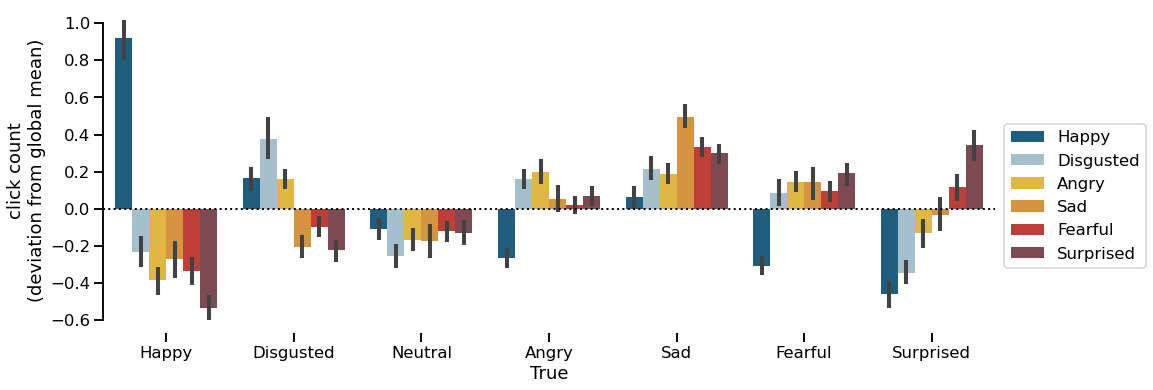

In [22]:
plt.figure(figsize=(16, 6))

sns.barplot(data=long_df, 
            x='True', 
            y='click count\n(deviation from global mean)', 
            hue='AU-Emo',
            order=my_order,
            palette=hue_palette,
            ci=my_ci,
            hue_order=hue_order
           )

plt.legend(loc=(1.01, 0.2))
sns.despine(bottom=True, trim=True)
plt.axhline(0, linestyle=':', color='k', linewidth=2)
#plt.ylim(0, 2)
plt.show()

with individual data points

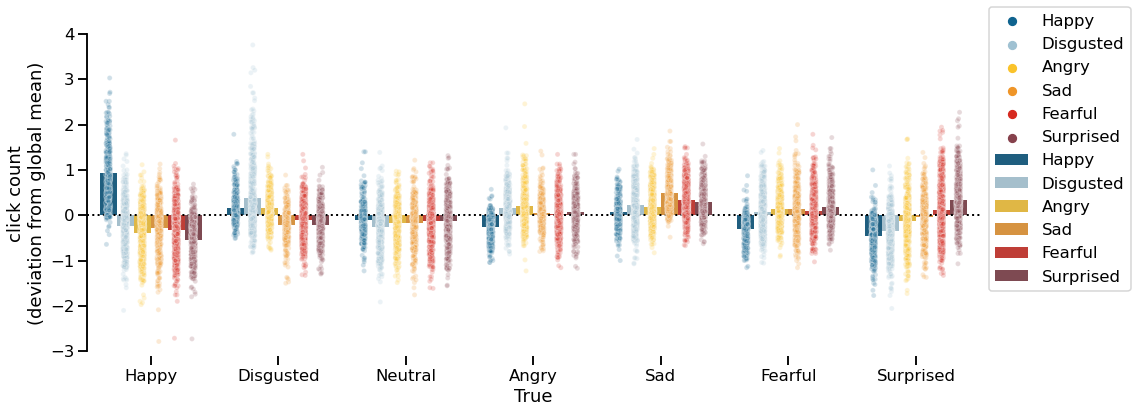

In [23]:
plt.figure(figsize=(16, 6))

sns.barplot(data=long_df, 
            x='True', 
            y='click count\n(deviation from global mean)', 
            hue='AU-Emo',
            order=my_order,
            palette=hue_palette,
            ci=my_ci,
            hue_order=hue_order
           )

sns.stripplot(data=long_df, 
              x='True', 
              y='click count\n(deviation from global mean)', 
              hue='AU-Emo',
              order=my_order,
              dodge=True,
              palette=hue_palette,
              edgecolor='white',
              linewidth=1,
              hue_order=hue_order,
              alpha=0.2
             )

plt.legend(loc=(1.01, 0.2))
sns.despine(bottom=True, trim=True)
plt.axhline(0, linestyle=':', color='k', linewidth=2)
#plt.ylim(0, 2)
plt.show()

### split into individual AUs

#### this is to get the colors right

In [24]:
au_colors = []
au_order = []
for emo, au in full_df.loc[:, hue_order].columns:
    
    this_n = np.where(np.array(my_order) == emo)[0][0]
    this_color = palette7[this_n]
    au_colors.append(this_color)
    au_order.append(au)

#### plot

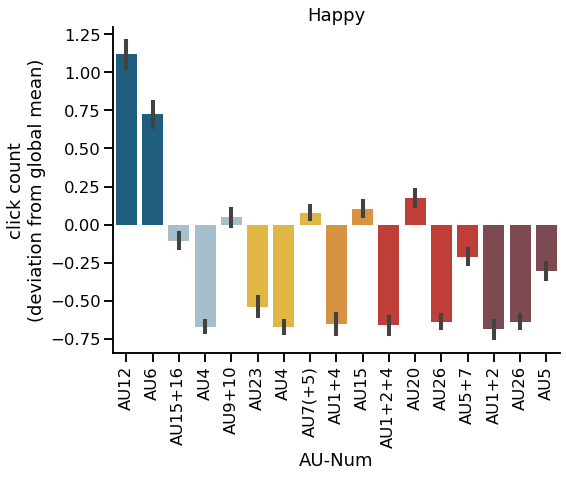

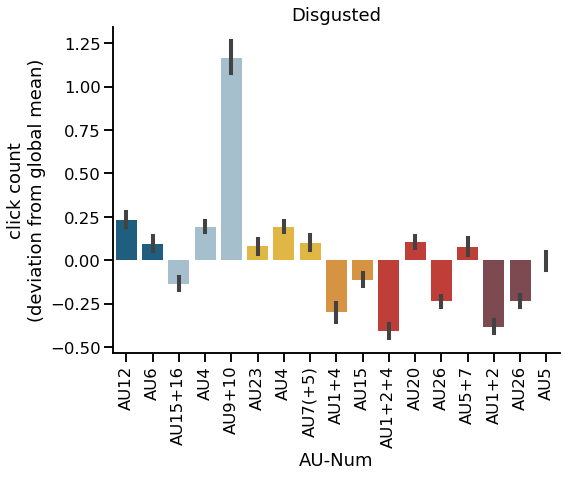

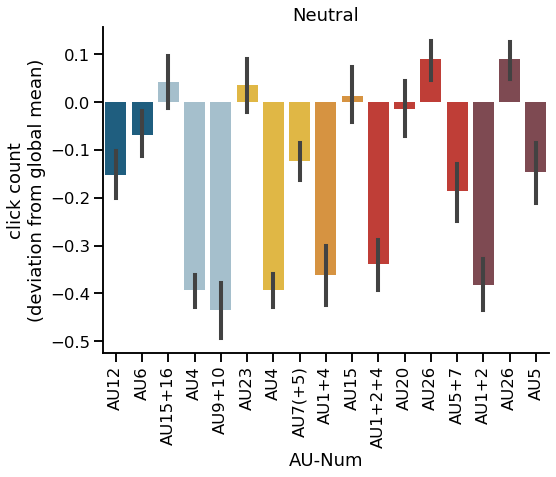

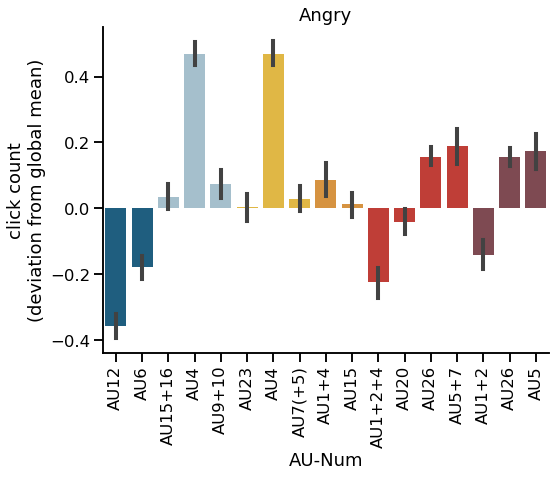

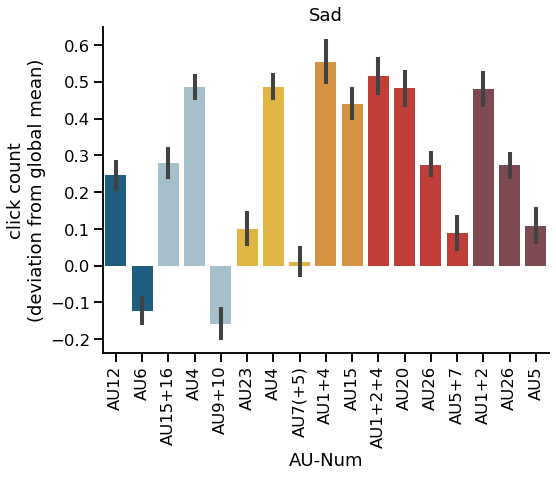

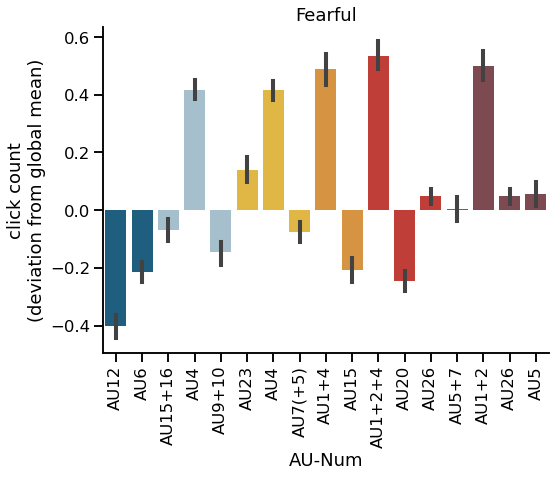

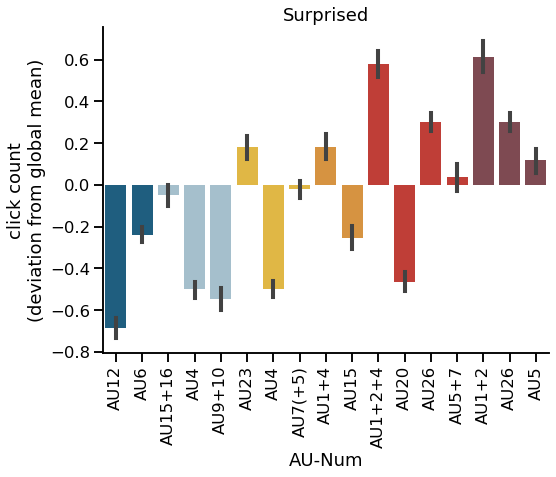

In [25]:
for emo in my_order:
    
    this_df = long_df[long_df.loc[:, 'True']==emo]
    
    plt.figure(figsize=(8, 6))
    sns.barplot(data=this_df, 
                x='AU-Num', 
                y='click count\n(deviation from global mean)',
                order=au_order,
                palette=au_colors
               )
    plt.xticks(rotation=90)
    sns.despine()
    plt.title(emo)
    plt.show()

## Make big plot

### differentiate between lower and upper AUs

Get the number of the AU from the ```au_order``` list, by using a regex which searches for the first number

In [26]:
au_order[0]

'AU12'

In [27]:
regex = re.compile(r'AU(\d+).*')

In [28]:
regex.findall( au_order[0] )

['12']

Do for all and store in Dictionary

In [29]:
d = {}
for i in au_order:
    d[i] = int(regex.findall(i)[-1])

In [30]:
emo_list = full_df.loc[:, hue_order].columns.get_level_values(0)
emo_list

Index(['Happy', 'Happy', 'Disgusted', 'Disgusted', 'Disgusted', 'Angry',
       'Angry', 'Angry', 'Sad', 'Sad', 'Fearful', 'Fearful', 'Fearful',
       'Fearful', 'Surprised', 'Surprised', 'Surprised'],
      dtype='object')

### Make plot

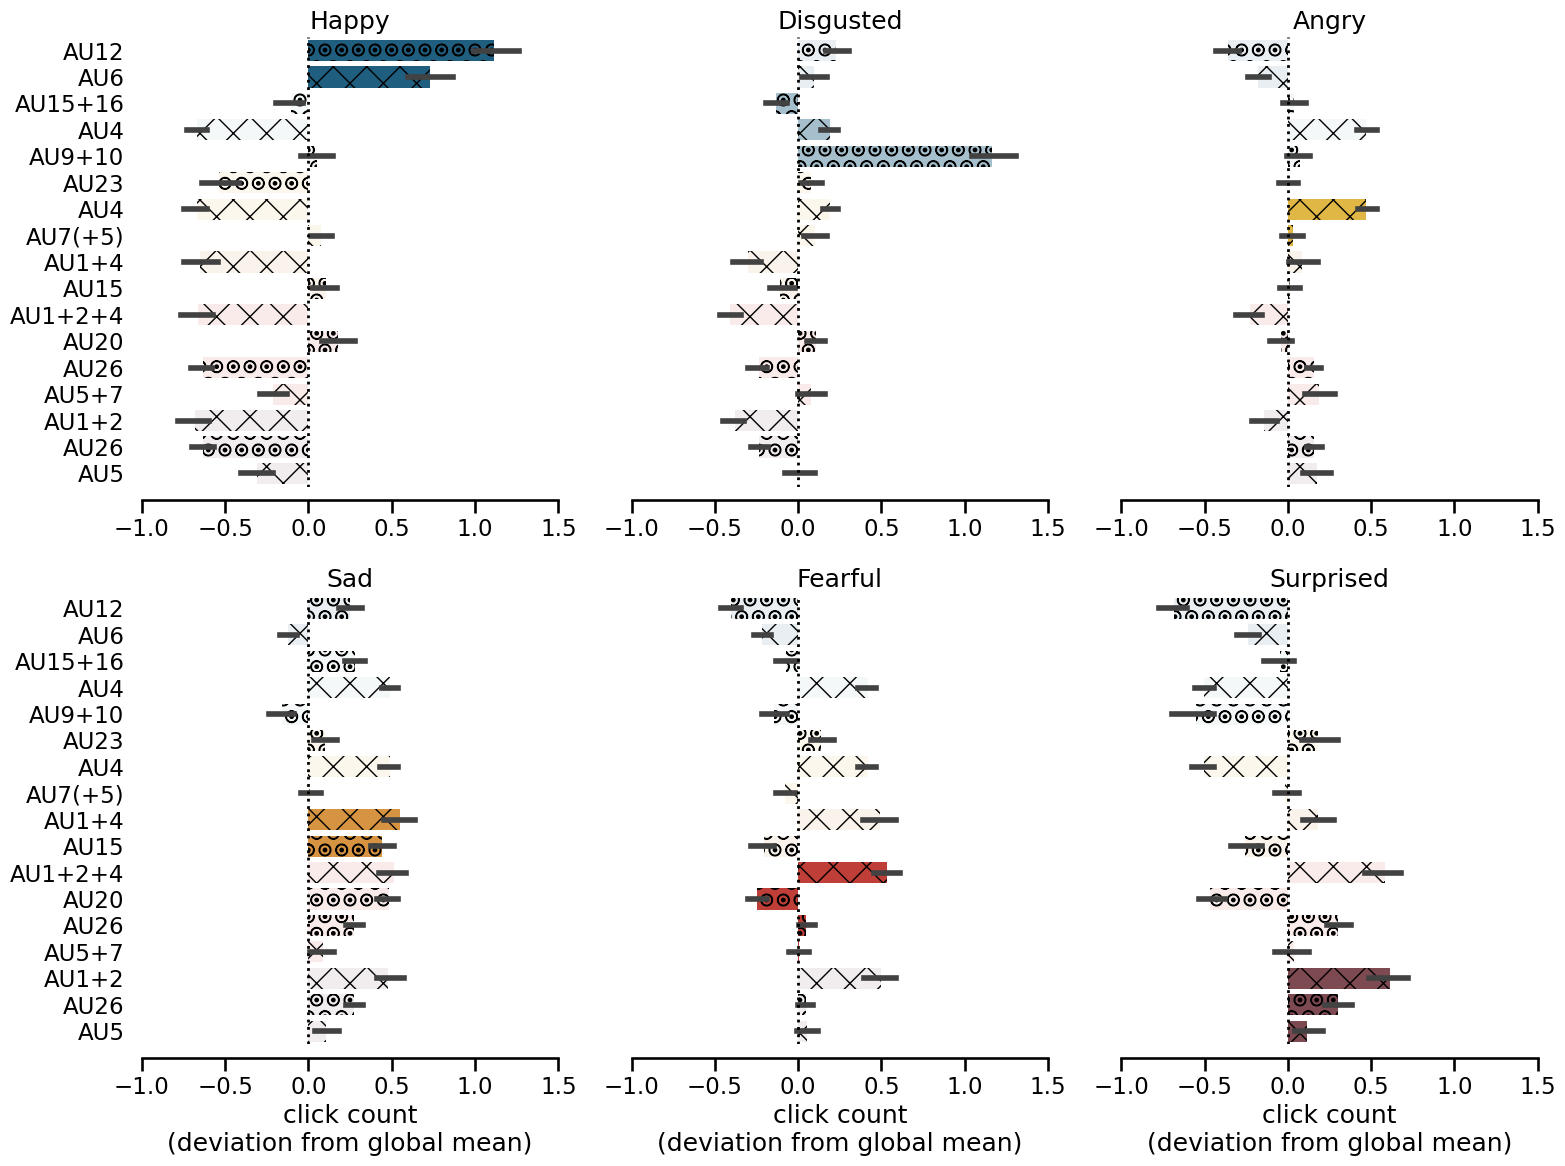

In [31]:
fig = plt.figure(figsize=(16, 12), dpi=100)

for n, emo in enumerate(hue_order):

    ax = plt.subplot(2, 3, n+1)
    
    this_df = long_df[long_df.loc[:, 'True']==emo]
    
    sns.barplot(data=this_df, 
                y='AU-Num', 
                x='click count\n(deviation from global mean)',
                order=au_order,
                palette=au_colors,
                ci=my_ci,
                ax=ax,
               )

    this_alphas = [(0.1, 1)[i==emo] for i in emo_list]
    for bar, alpha in zip(ax.containers[0], this_alphas ):
        bar.set_alpha(alpha)
    
    if (n+3)%3!=0:
        ax.set_yticks([])
    else:
        ax.set_yticks(range(len(au_order)))
        ax.set_yticklabels(au_order, rotation=0)

    if n <3:
        ax.set_xlabel('')
    
    ax.axvline(0, linestyle=':', color='k', linewidth=2)

    ax.set_xlim(-1.0, 1.5)
    ax.set_ylabel('')    
    ax.tick_params(left=False)

    ax.set_title(emo, y=1)

    sns.despine(left=True, trim=True, offset=10)
    
    # give patterns to bars    
    for label, patch in zip(au_order, ax.patches):
        num = d[label]
        if num < 9: # AUs with numbers below 9 refer to the upper face half* (*there are also some above #40 but these are not used here, also AU9 could be considered to belong to both halves) 
            hatch = '/\\'
        else:
            hatch = 'O.'
        
        patch.set_hatch(hatch)

plt.tight_layout()
#plt.savefig('../reports/figures/au_fig.png', dpi=300, bbox_inches='tight')

plt.show()   

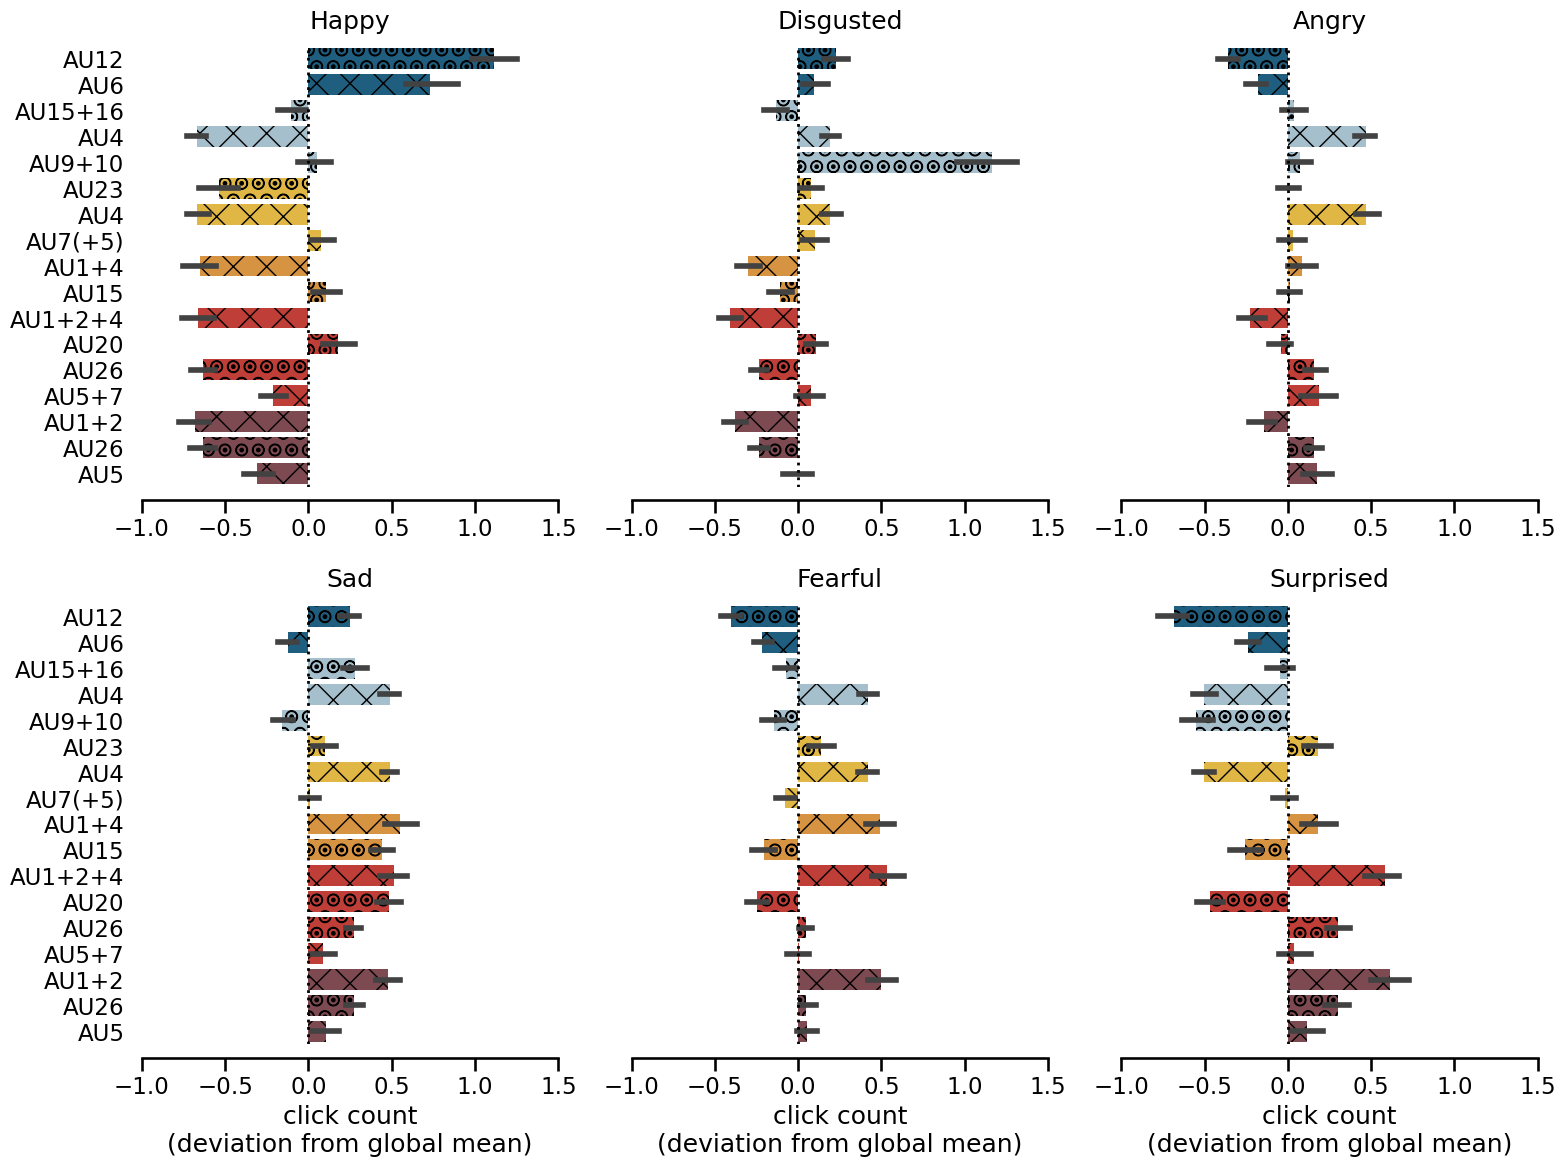

In [32]:
fig = plt.figure(figsize=(16, 12), dpi=100)

for n, emo in enumerate(hue_order):

    ax = plt.subplot(2, 3, n+1)
    
    this_df = long_df[long_df.loc[:, 'True']==emo]
    
    sns.barplot(data=this_df, 
                y='AU-Num', 
                x='click count\n(deviation from global mean)',
                order=au_order,
                palette=au_colors,
                ci=my_ci,
                ax=ax,
               )

    #this_alphas = [(0.1, 1)[i==emo] for i in emo_list]
    #for bar, alpha in zip(ax.containers[0], this_alphas ):
    #    bar.set_alpha(alpha)
    
    if (n+3)%3!=0:
        ax.set_yticks([])
    else:
        ax.set_yticks(range(len(au_order)))
        ax.set_yticklabels(au_order, rotation=0)

    if n <3:
        ax.set_xlabel('')
    
    ax.axvline(0, linestyle=':', color='k', linewidth=2)

    ax.set_xlim(-1.0, 1.5)
    ax.set_ylabel('')    
    ax.tick_params(left=False)

    ax.set_title(emo, y=1.02, fontsize=18)

    sns.despine(left=True, trim=True, offset=10)
    
    # give patterns to bars    
    for label, patch in zip(au_order, ax.patches):
        num = d[label]
        if num < 9: # AUs with numbers below 9 refer to the upper face half* (*there are also some above #40 but these are not used here, also AU9 could be considered to belong to both halves) 
            hatch = '/\\'
        else:
            hatch = 'O.'
        
        patch.set_hatch(hatch)

plt.tight_layout()
plt.savefig('../reports/figures/au_fig.png', dpi=300, bbox_inches='tight')

plt.show()   

### check which AU is most important

In [33]:
long_df.tail()

pnum       True     AU-Emo AU-Num  \
24033  p233    Fearful  Surprised    AU5   
24034  p233      Happy  Surprised    AU5   
24035  p233    Neutral  Surprised    AU5   
24036  p233        Sad  Surprised    AU5   
24037  p233  Surprised  Surprised    AU5   

       click count\n(deviation from global mean)  
24033                                  -0.528571  
24034                                  -0.228571  
24035                                  -0.028571  
24036                                  -0.228571  
24037                                   0.371429

average over participants

In [34]:
mean_long_df = long_df.groupby(['True', 'AU-Emo', 'AU-Num']).mean()
mean_long_df.tail()

click count\n(deviation from global mean)
True      AU-Emo    AU-Num                                           
Surprised Sad       AU1+4                                    0.182320
                    AU15                                    -0.254597
          Surprised AU1+2                                    0.611174
                    AU26                                     0.303182
                    AU5                                      0.117751

reshape and remove neutral (because it has no AUs)

In [35]:
mean_au_df = mean_long_df.unstack(0).T.loc['click count\n(deviation from global mean)', :]
mean_au_df = mean_au_df.drop('Neutral')
mean_au_df = mean_au_df.loc[hue_order, hue_order]

In [36]:
mean_au_df.style.highlight_max(axis=1)

### for each emotion, which is the AU with the highest value?

In [37]:
these_max = (mean_au_df.T == mean_au_df.max(axis=1)).idxmax()
these_max

True
Happy              (Happy, AU12)
Disgusted    (Disgusted, AU9+10)
Angry               (Angry, AU4)
Sad                 (Sad, AU1+4)
Fearful       (Fearful, AU1+2+4)
Surprised     (Surprised, AU1+2)
dtype: object

#### Do all match?

In [38]:
(these_max.index == these_max.apply(lambda x:x[0])).all()

True